# Set-up

In [14]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import random
from tqdm.notebook import tqdm, trange

sns.set_theme()
colors = sns.color_palette("deep")

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from utils import geometric_median, geometric_medoid
from math import floor, ceil, sqrt

In [27]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [50]:
def plot_components(H_dict, nrows=None, ncols=None, figsize=(20, 10)):
    if nrows is None and ncols is None:
        nrows = floor(sqrt(len(H_dict)))
        ncols = ceil(len(H_dict) / nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharey=True)

    for idx, (method, H) in enumerate(H_dict.items()):
        i = idx // ncols
        j = idx % ncols
        
        abscissa = np.linspace(0, 24, H.shape[1])
        for k in range(H.shape[0]):
            label = f'Component {k + 1}'
            if 'smoothed' in method:
                marker=None
            else:
                marker = 'o'
            axs[i,j].plot(abscissa, H[k, :], marker=marker, linestyle='-', label=label)
        
        axs[i,j].set_xlabel('Hour')
        # axs[i,j].set_ylabel('Normalized Load')
        axs[i,j].set_title(method)
        axs[i,j].legend()
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [96]:
def plot_residual_curves(residuals_dict, n_curves_plotted=100, nrows=None, ncols=None, figsize=(20, 10), **kwargs):
    if nrows is None and ncols is None:
        nrows = floor(sqrt(len(residuals_dict)))
        ncols = ceil(len(residuals_dict) / nrows)
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False, sharey=True)

    for idx, (method, residuals) in enumerate(residuals_dict.items()):
        i = idx // ncols
        j = idx % ncols
        
        for n in random.sample(range(residuals.shape[0]), n_curves_plotted):
            axs[i,j].plot(residuals[n, :], marker='o', linestyle='-', color=colors[0], **kwargs)
        
        axs[i,j].set_xlabel('Hour')
        # axs[i,j].set_ylabel('Normalized Load')
        axs[i,j].set_title(method)
        # axs[i,j].legend()
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [143]:
def plot_residual_boxplots(residuals_with_info, nrows=None, ncols=None, figsize=(15, 7), rotate_xlabels=False, **kwargs):
    nrows = floor(sqrt(len(residuals_with_info)))
    ncols = ceil(len(residuals_with_info) / nrows)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)

    for idx, (method, resid_df)  in enumerate(residuals_with_info.items()):
        i = idx // ncols
        j = idx % ncols
        sns.boxplot(
            resid_df,
            y='residual',
            ax=axs[i, j],
            **kwargs
        )
        axs[i, j].set_title(method)
        if rotate_xlabels:
            axs[i, j].tick_params(axis='x', rotation=45)
    plt.subplots_adjust(wspace=0.05)
    return fig, axs

In [4]:
max_n_components = 4
colormap = ListedColormap([colors[k] for k in range(max_n_components)])

# Load results and input data

## Results

In [56]:
method_names = [
    'WHopt_3comp_1000runs',
    'WHopt_4comp_1000runs',
    'WHopt_3comp_smoothed_1000runs',
    'WHopt_4comp_smoothed_1000runs'
]
W = {}
H = {}

for method in method_names:
    data = np.load('data/nmf_results/' + method + '.npz', allow_pickle=True)
    W[method] = data['W']
    H[method] = data['H']

## Input data

In [11]:
input_df = pd.read_csv('data/daily_curves_fixed.csv', index_col=0)
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
print(len(df))
df.head(3)

11646


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,region,year,month,daytype
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,828.180,831.509,758.732,669.630,596.548,518.853,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,819.056,825.176,754.773,706.062,629.708,540.431,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,980.735,926.445,845.014,756.975,688.183,601.762,Calabria,2021,01,Working day


In [67]:
X = df.drop(unit_info.columns, axis=1)
# We want to keep a functional l1 norm of 1. In case of 15min interval load measures (so 97 measures), we normalise by the l1 norm of the vector divided by int(97 / 24) = 4
X = X.div(X.sum(axis=1), axis=0) * int(X.shape[1] / 24)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Calabria_2021-01-02_Saturday,0.035550,0.033102,0.029717,0.028863,0.029419,0.029717,0.031670,0.033844,0.037269,0.041676,...,0.041718,0.042351,0.047951,0.049726,0.053246,0.053460,0.048781,0.043052,0.038354,0.033358
Calabria_2021-01-03_Holiday,0.033443,0.029513,0.027858,0.027011,0.025395,0.028277,0.029806,0.031487,0.034317,0.041372,...,0.043736,0.042965,0.047074,0.049257,0.052793,0.053187,0.048649,0.045510,0.040588,0.034834
Calabria_2021-01-04_Working day,0.029862,0.024866,0.023982,0.023923,0.024048,0.025256,0.028566,0.034543,0.038185,0.048945,...,0.046710,0.044101,0.048085,0.049247,0.054191,0.051191,0.046692,0.041827,0.038026,0.033251
Calabria_2021-01-05_Working day,0.033850,0.030881,0.029073,0.028775,0.027999,0.029155,0.032742,0.037978,0.041914,0.052139,...,0.044708,0.042871,0.046004,0.049792,0.050000,0.048766,0.044880,0.038781,0.034489,0.029378
Calabria_2021-01-06_Holiday,0.032438,0.028625,0.027462,0.027464,0.026969,0.027740,0.028923,0.031700,0.034598,0.044711,...,0.045380,0.042887,0.045624,0.049557,0.050506,0.049244,0.046810,0.042910,0.038848,0.034480


# Compare profiles found

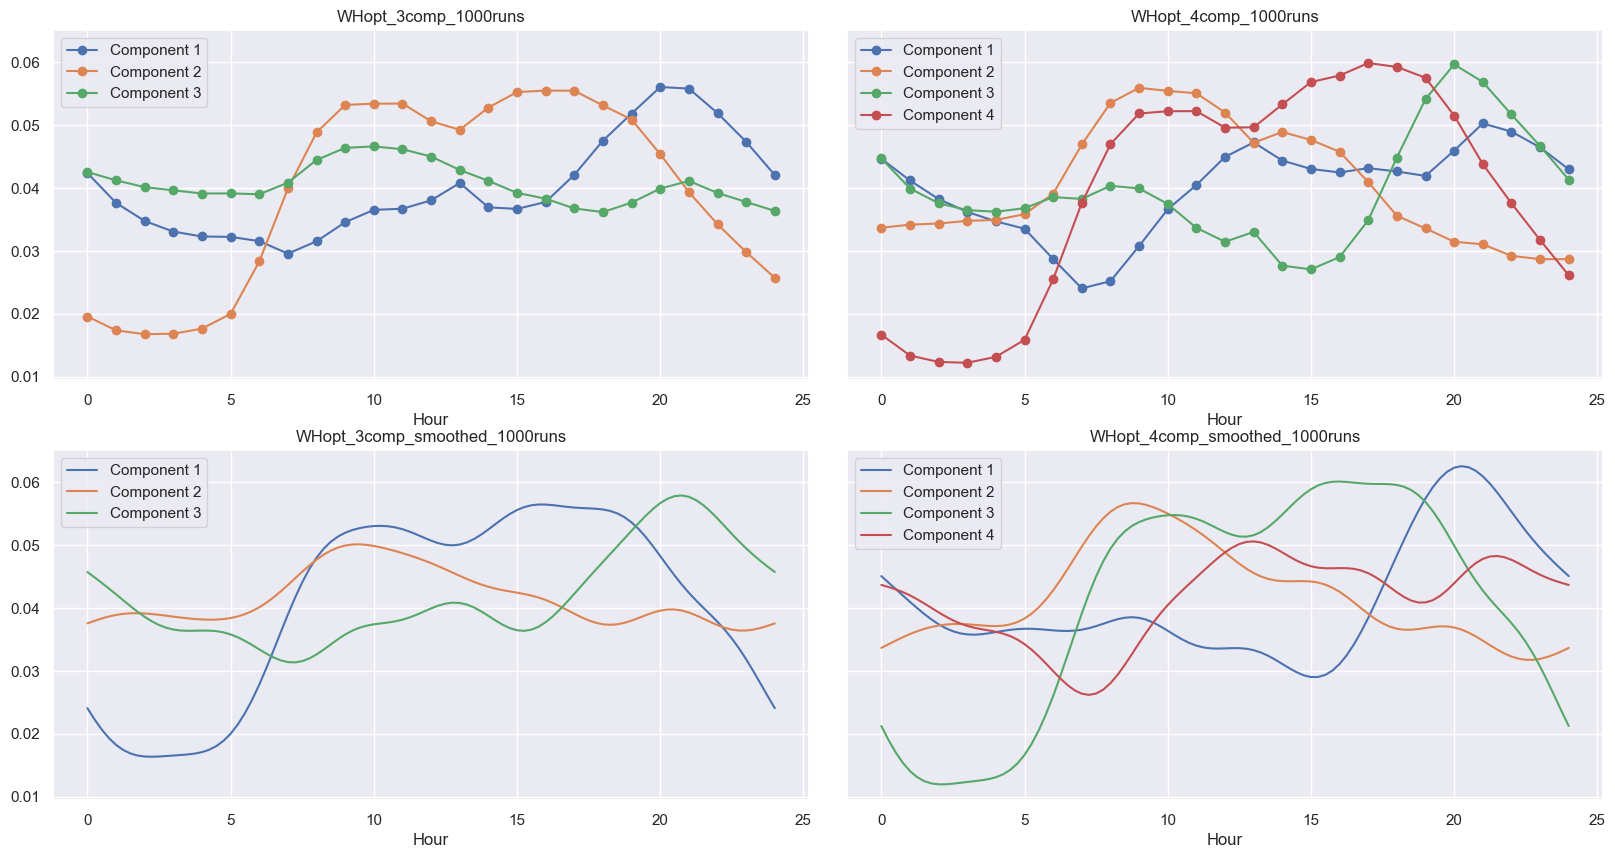

In [59]:
fig, axs = plot_components(H, nrows=2, ncols=2, figsize=(20, 10))

# Assess homoschedasticity assumption of the errors

In [74]:
reconstructed = {}
residuals = {}

for method in method_names:
    reconstructed_smooth = np.dot(W[method], H[method])
    n_eval_points = H[method].shape[1]
    reconstructed[method] = reconstructed_smooth[:, np.arange(0, n_eval_points, int(n_eval_points / 24))]
    residuals[method] = X.values - reconstructed[method]

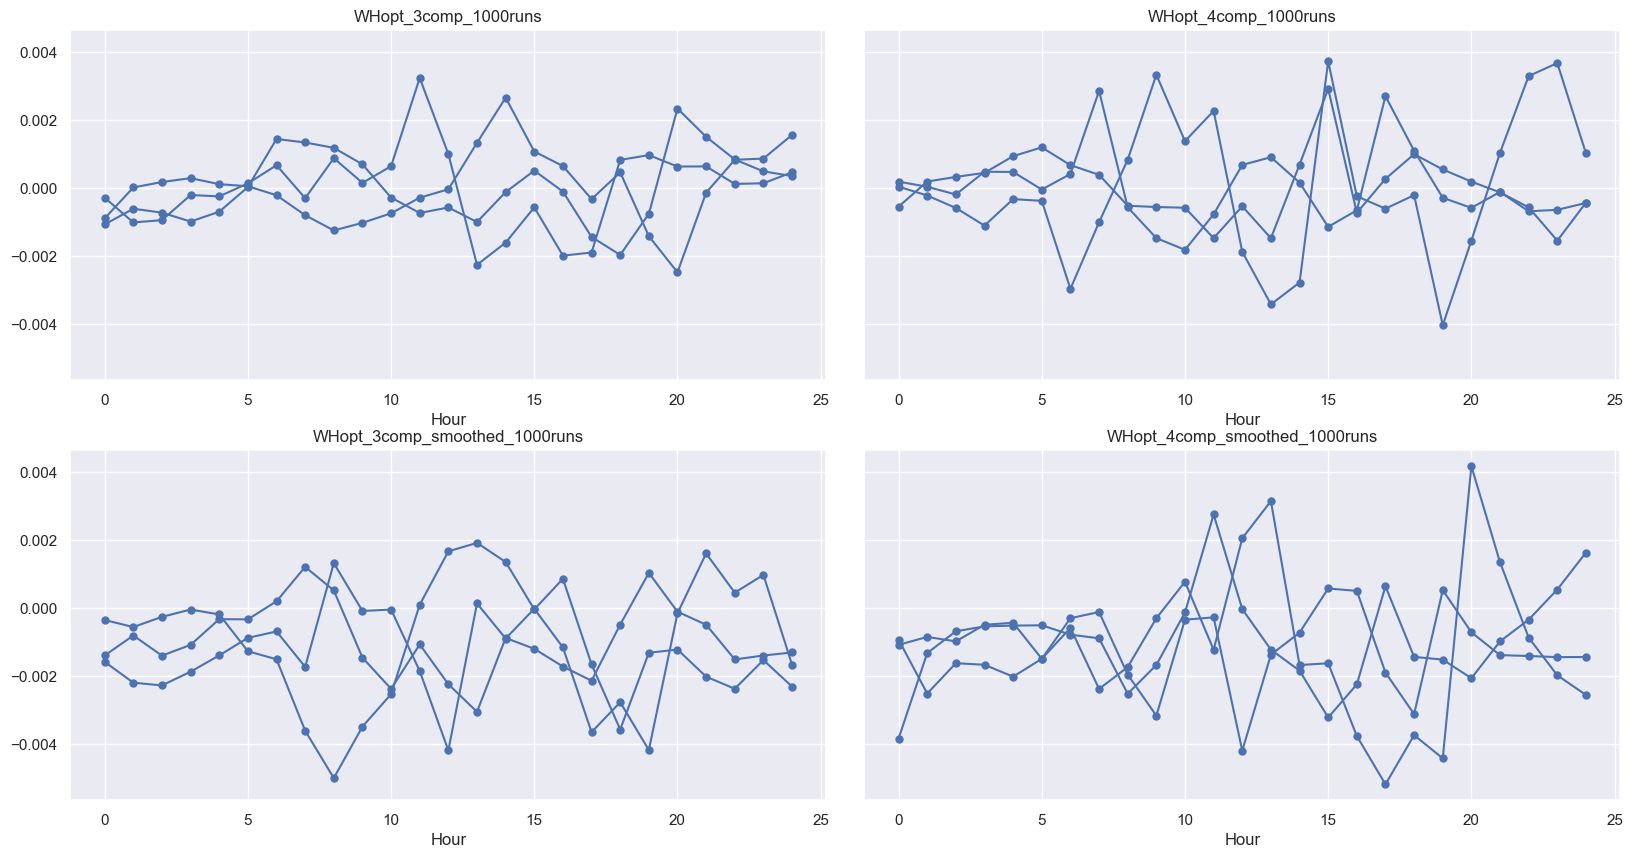

In [102]:
fig, axs = plot_residual_curves(residuals, n_curves_plotted=3, nrows=2, ncols=2, figsize=(20, 10), markersize=5)

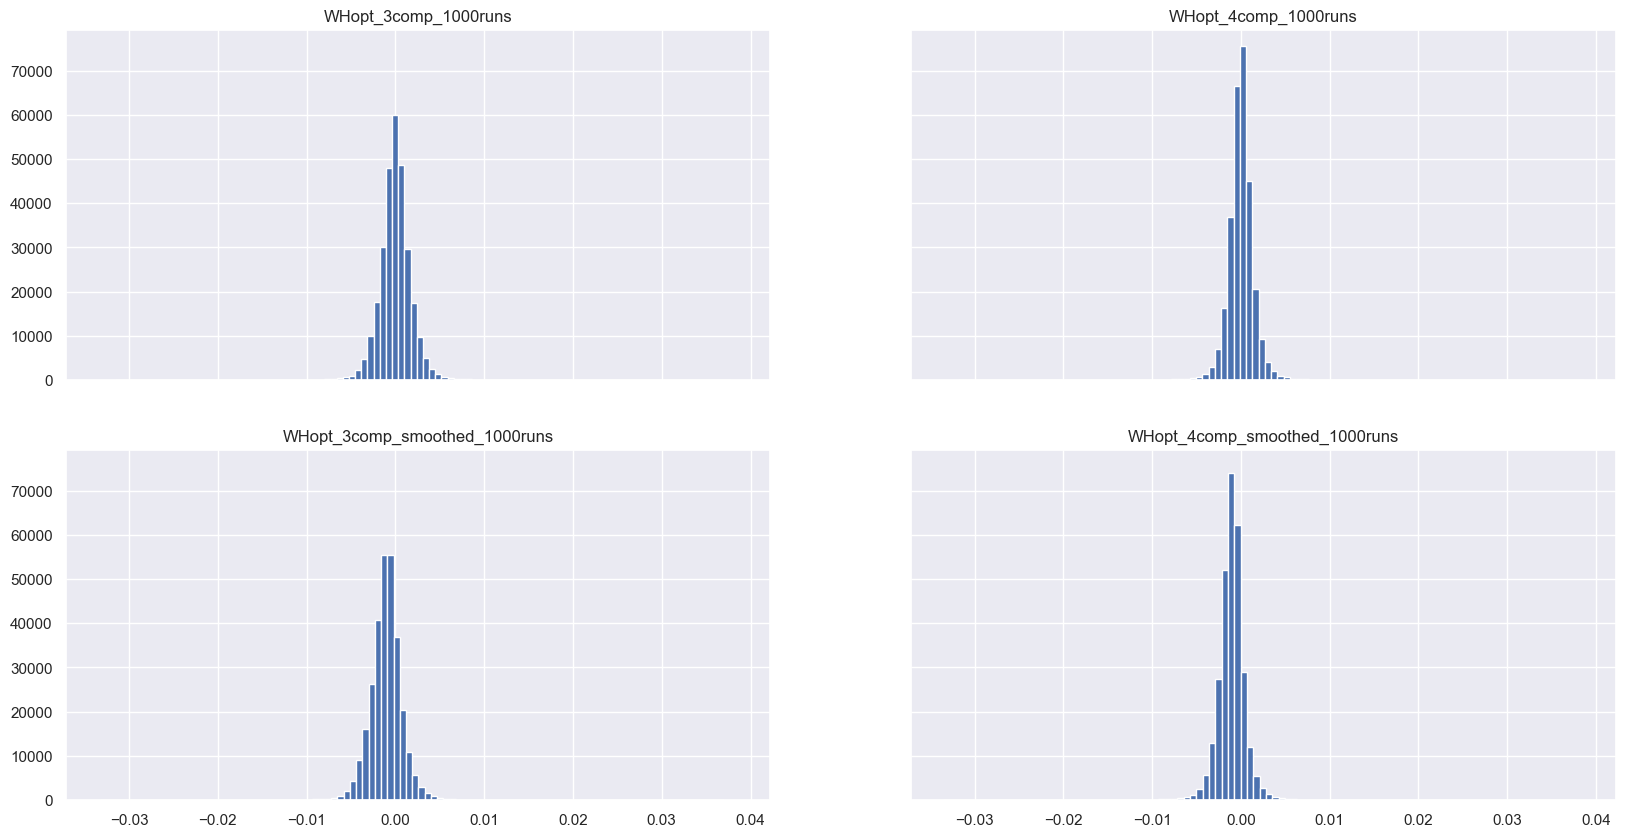

In [110]:
nrows = floor(sqrt(len(method_names)))
ncols = ceil(len(method_names) / nrows)

fig, axs = plt.subplots(nrows, 2, figsize=(20, 10), sharex=True, sharey=True)

for idx, (method, E)  in enumerate(residuals.items()):
    resid = E.flatten()
    i = idx // ncols
    j = idx % ncols
    axs[i, j].hist(resid, bins=100)
    axs[i, j].set_title(method)

In [113]:
residuals_with_info = {}

for method in method_names:
    resid_df = pd.concat([pd.DataFrame(residuals[method], index=input_df.index), unit_info], axis=1)
    resid_df = resid_df.melt(id_vars=unit_info.columns.to_list(), var_name='hour', value_name='residual')
    residuals_with_info[method] = resid_df

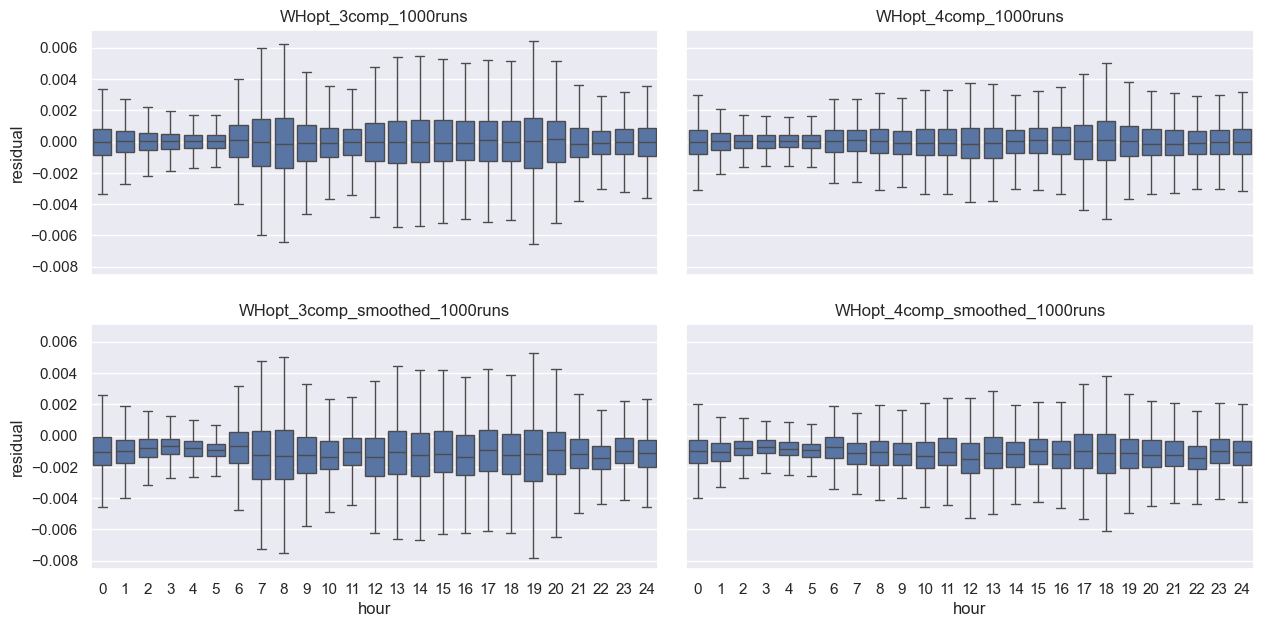

In [123]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='hour', showfliers=False)

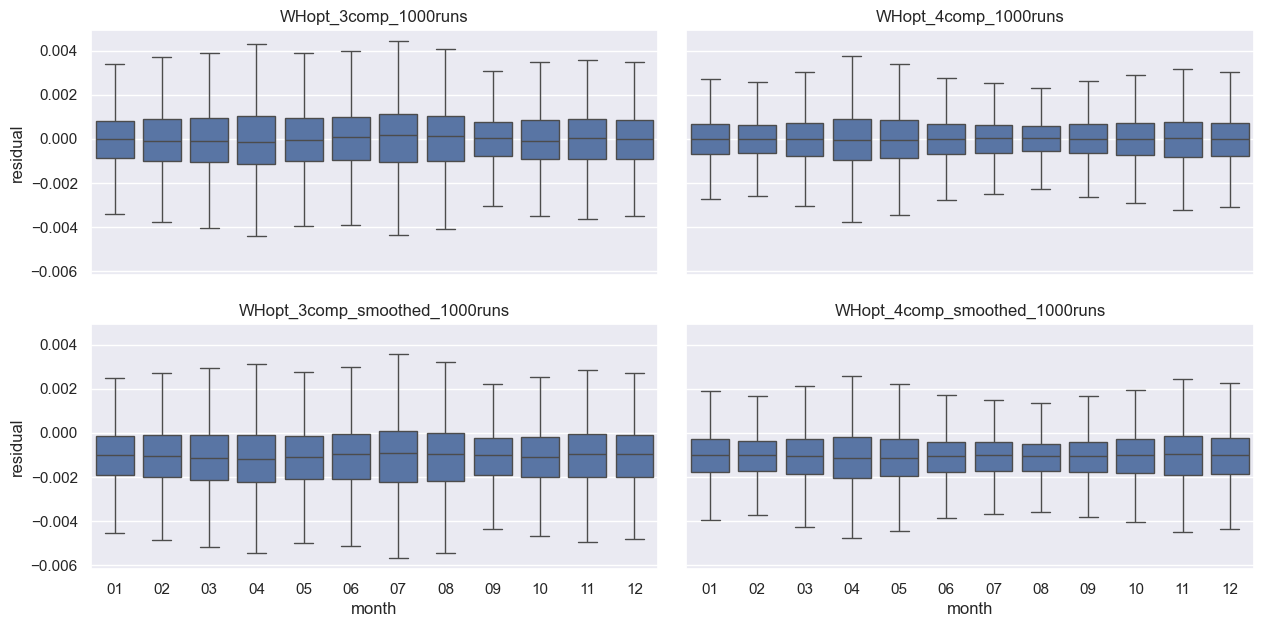

In [125]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='month', showfliers=False)

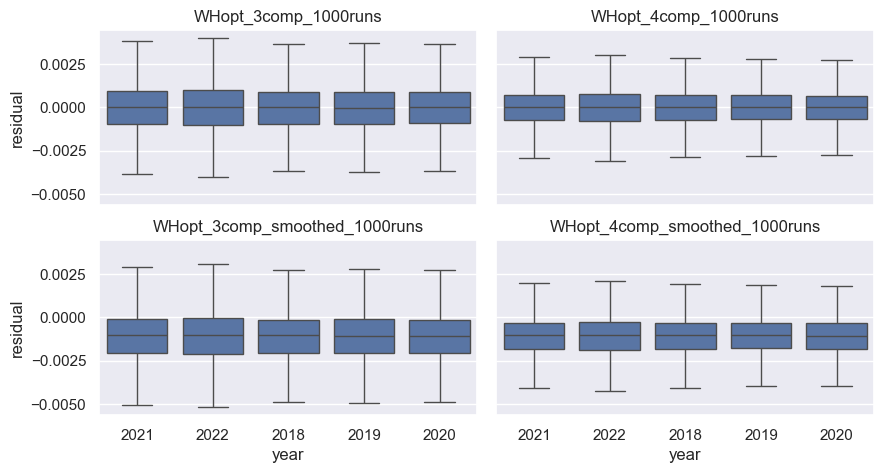

In [131]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='year', showfliers=False, figsize=(10,5))

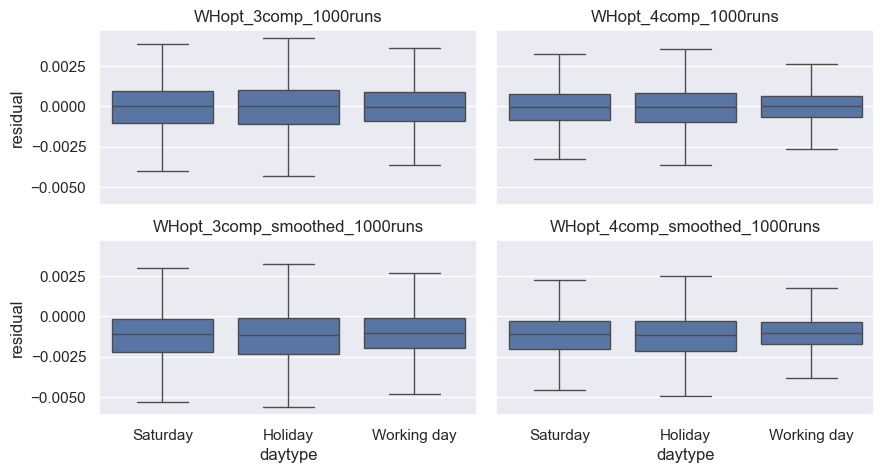

In [132]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='daytype', showfliers=False, figsize=(10,5))

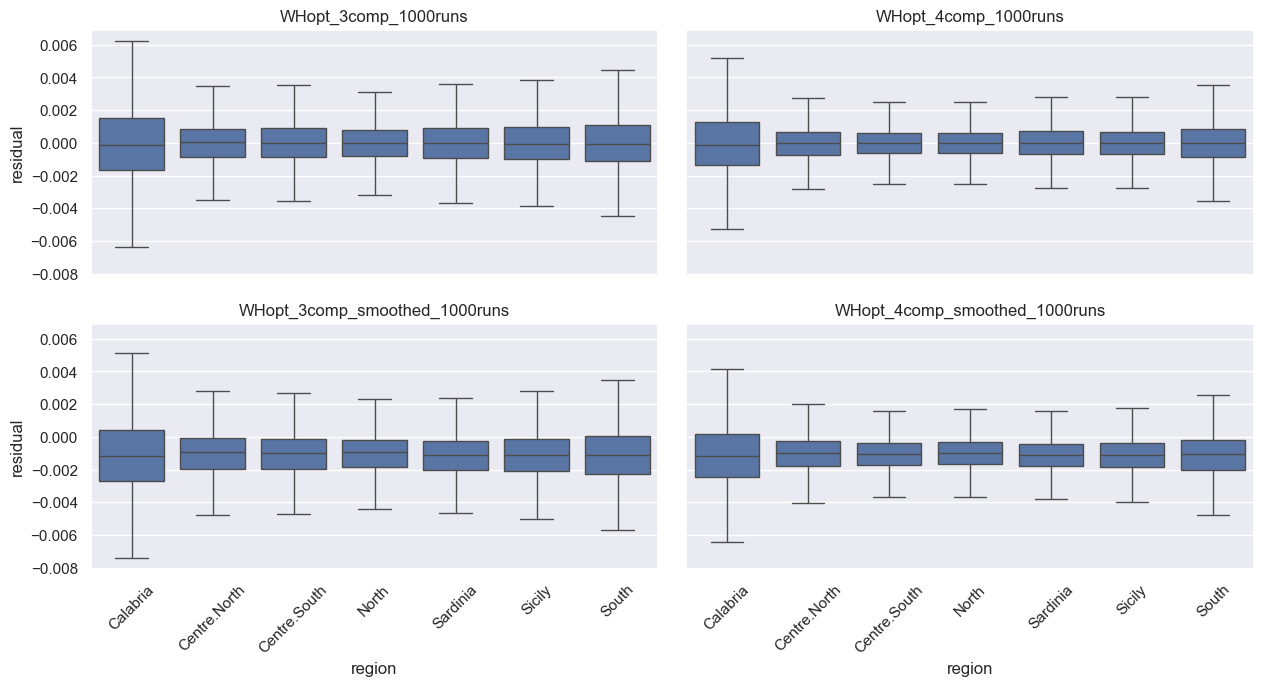

In [144]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='region', showfliers=False, rotate_xlabels=True)

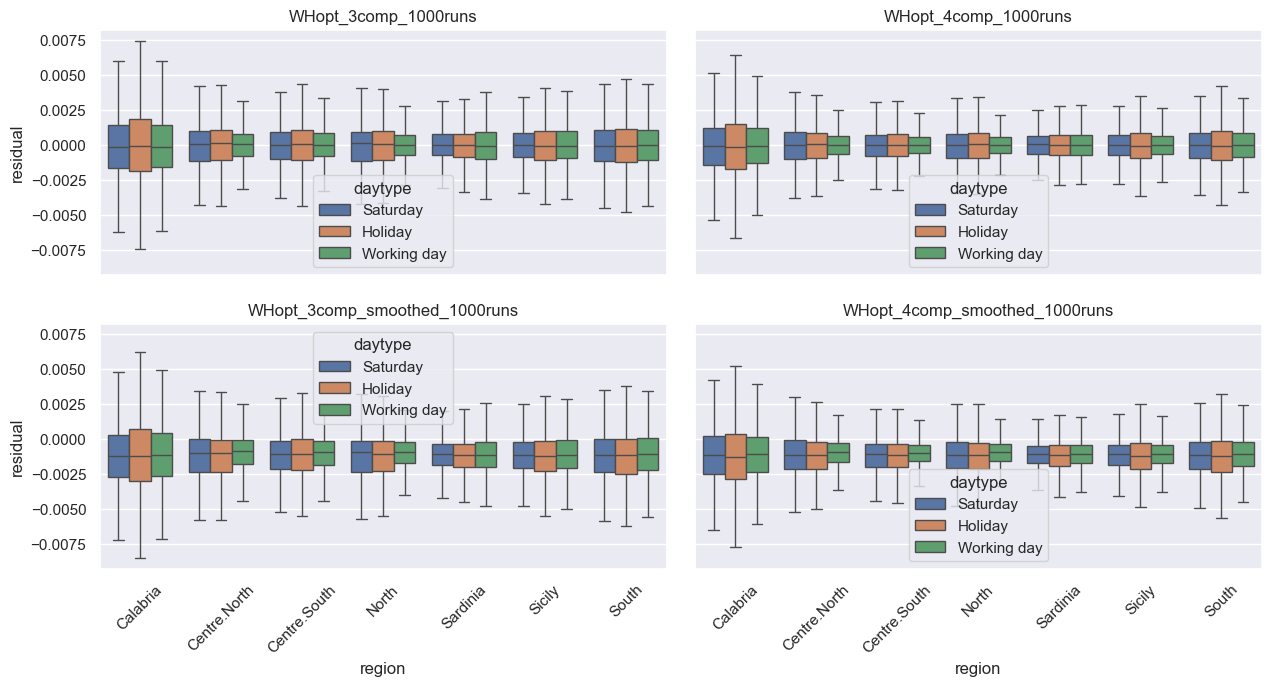

In [145]:
fig, axs = plot_residual_boxplots(residuals_with_info, x='region', showfliers=False, rotate_xlabels=True, hue='daytype')

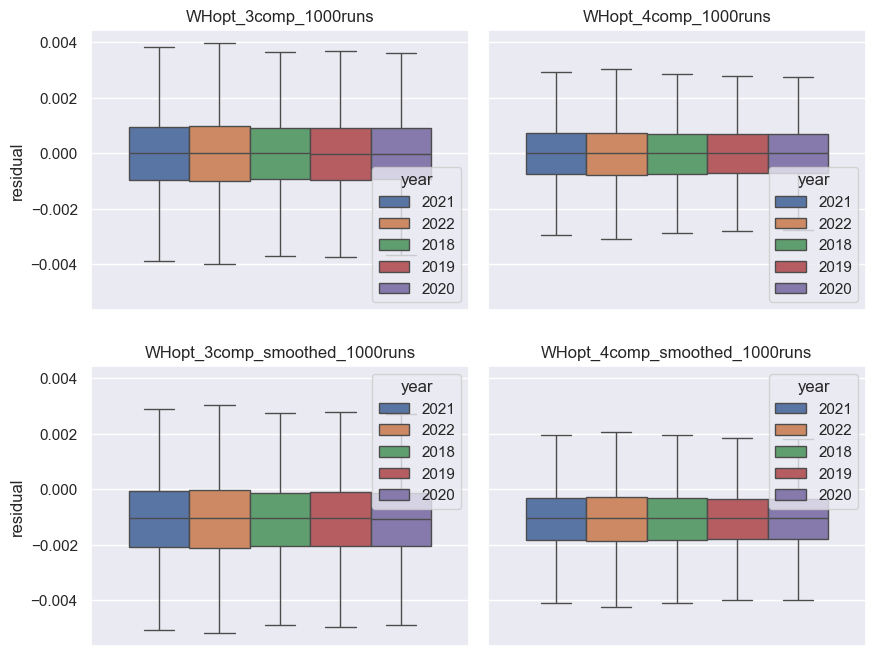

In [149]:
fig, axs = plot_residual_boxplots(residuals_with_info, showfliers=False, figsize=(10,8), hue='year')

In [124]:
unit_info

,region,year,month,daytype
Calabria_2021-01-02_Saturday,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,Calabria,2021,01,Working day
Calabria_2021-01-06_Holiday,Calabria,2021,01,Holiday
...,...,...,...,...
South_2022-12-26_Holiday,South,2022,12,Holiday
South_2022-12-27_Working day,South,2022,12,Working day
South_2022-12-28_Working day,South,2022,12,Working day
South_2022-12-29_Working day,South,2022,12,Working day
